In [1]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import shap
import xgboost
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

/mnt/3273eabb-9e14-47b4-8ddd-ddb77dddcd30/workspace/RossmannSalesForecasting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_data_folder = "data"
raw_data_folder = os.path.join(root_data_folder, "raw")
processed_data_folder = os.path.join(root_data_folder, "processed")

In [3]:
stores_sales_df = pd.read_parquet(
    os.path.join(processed_data_folder, "stores-sales.parquet")
)[["Store", "StoreType", "StateHoliday", "Promo", "Sales"]]

stores_sales_df["StateHoliday"] = stores_sales_df["StateHoliday"].map(
    {"0": 0, "a": 1, "b": 2, "c": 3}
)

stores_sales_df["StoreType"] = stores_sales_df["StoreType"].map(
    {"a": 0, "b": 1, "c": 2, "d": 3}
)

stores_sales_df

,Store,StoreType,StateHoliday,Promo,Sales
Date,,,,,
2013-01-01,1115,3,1,0,0
2013-01-01,746,3,1,0,0
2013-01-01,171,0,1,0,0
2013-01-01,694,0,1,0,0
2013-01-01,396,0,1,0,0
...,...,...,...,...,...
2015-07-31,612,3,0,1,8161
2015-07-31,235,0,0,1,6756
2015-07-31,1078,3,0,1,9732


In [4]:
weekly_stores_sales_df = stores_sales_df.groupby("Store").resample("W").agg({
    "Sales": "sum",
    "StateHoliday": "max",
    "Promo": "max",
    "StoreType": "max"
}).reset_index()

weekly_stores_sales_df

,Store,Date,Sales,StateHoliday,Promo,StoreType
0,1,2013-01-06,19340,1.0,0.0,2.0
1,1,2013-01-13,32952,0.0,1.0,2.0
2,1,2013-01-20,25978,0.0,0.0,2.0
3,1,2013-01-27,33071,0.0,1.0,2.0
4,1,2013-02-03,28693,0.0,0.0,2.0
...,...,...,...,...,...,...
150520,1115,2015-07-05,48130,0.0,1.0,3.0
150521,1115,2015-07-12,36233,0.0,0.0,3.0
150522,1115,2015-07-19,45927,0.0,1.0,3.0
150523,1115,2015-07-26,35362,0.0,0.0,3.0


In [5]:
validation_weekly_stores_sales_df = weekly_stores_sales_df[weekly_stores_sales_df.Date > "2015-02"]
weekly_stores_sales_df = weekly_stores_sales_df[weekly_stores_sales_df.Date < "2015-02"]

In [6]:
sales_transform = StandardScaler()

weekly_stores_sales_df["Sales"] = sales_transform.fit_transform(weekly_stores_sales_df[["Sales"]]).squeeze()
weekly_stores_sales_df = pd.get_dummies(weekly_stores_sales_df, columns=["StateHoliday"])

In [7]:
weekly_stores_sales_df["Year"] = weekly_stores_sales_df["Date"].dt.year
weekly_stores_sales_df["Month"] = weekly_stores_sales_df["Date"].dt.month
weekly_stores_sales_df["WeekOfYear"] = weekly_stores_sales_df["Date"].dt.isocalendar().week

In [8]:
weekly_stores_sales_df["Sales_Lag1"] = weekly_stores_sales_df.groupby("Store")["Sales"].shift(1)
weekly_stores_sales_df["Sales_Lag2"] = weekly_stores_sales_df.groupby("Store")["Sales"].shift(2)

weekly_stores_sales_df["Sales_2Week_Avg"] = (
    weekly_stores_sales_df
        .groupby("Store")["Sales"]
        .rolling(window=2)
        .mean()
        .shift(1)
        .reset_index(drop=True)
)

weekly_stores_sales_df = weekly_stores_sales_df.dropna()
weekly_stores_sales_df

,Store,Date,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
2,1,2013-01-20,-0.688314,0.0,2.0,True,False,False,False,2013,1,3,-0.303893,-1.054214,-0.679053
3,1,2013-01-27,-0.297333,1.0,2.0,True,False,False,False,2013,1,4,-0.688314,-0.303893,-0.496103
4,1,2013-02-03,-0.538658,0.0,2.0,True,False,False,False,2013,2,5,-0.297333,-0.688314,-0.492824
5,1,2013-02-10,-0.148504,1.0,2.0,True,False,False,False,2013,2,6,-0.538658,-0.297333,-0.417996
6,1,2013-02-17,-0.583472,0.0,2.0,True,False,False,False,2013,2,7,-0.148504,-0.538658,-0.343581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120388,892,2014-12-28,0.045966,0.0,0.0,False,False,False,True,2014,12,52,2.205702,0.377691,-0.120309
120389,892,2015-01-04,-0.395451,0.0,0.0,False,True,False,False,2015,1,1,0.045966,2.205702,-0.199712
120390,892,2015-01-11,0.642662,1.0,0.0,True,False,False,False,2015,1,2,-0.395451,0.045966,-0.130975
120391,892,2015-01-18,0.510314,1.0,0.0,True,False,False,False,2015,1,3,0.642662,-0.395451,-0.011416


In [9]:
shuffled_weekly_stores_sales_df = weekly_stores_sales_df.copy()

shuffled_weekly_stores_sales_df["rnd_index"] = np.random.default_rng(seed=42).permutation(
    len(shuffled_weekly_stores_sales_df)
)

shuffled_weekly_stores_sales_df = (
    shuffled_weekly_stores_sales_df
        .set_index("rnd_index")
        .sort_index()
        .drop("Date", axis="columns")
)

shuffled_weekly_stores_sales_df

,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,,
0,838,0.584564,1.0,3.0,False,True,False,False,2014,5,18,-0.315248,0.880183,-0.685337
1,572,-0.443682,0.0,3.0,True,False,False,False,2014,3,11,0.556782,-0.321753,-0.076487
2,237,-0.517381,1.0,0.0,True,False,False,False,2014,7,27,-0.787864,-0.577023,0.021906
3,349,0.095080,0.0,2.0,True,False,False,False,2014,1,3,0.573760,-0.063065,-0.237168
4,721,-0.056340,0.0,0.0,True,False,False,False,2014,6,26,0.408449,-0.182294,0.044092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90264,736,-0.822426,0.0,2.0,True,False,False,False,2014,2,7,-0.042063,-0.752145,-0.230608
90265,801,-0.283443,1.0,3.0,True,False,False,False,2014,11,45,-0.773202,-0.565061,-0.450132
90266,198,-1.562549,0.0,0.0,False,True,False,False,2014,11,44,-1.034866,-1.522696,0.662975


In [10]:
train_features, train_sales = (
    shuffled_weekly_stores_sales_df.drop("Sales", axis="columns").values,
    shuffled_weekly_stores_sales_df[["Sales"]].values,
)

In [11]:
xgbr_regressor = XGBRegressor()

In [12]:
xgbr_regressor.fit(train_features, train_sales)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
mae = mean_absolute_error(train_sales, xgbr_regressor.predict(train_features))
mse = mean_squared_error(train_sales, xgbr_regressor.predict(train_features))

print(f"Train MAE: {mae:.4} -- Train MSE: {mse:.4}")

Train MAE: 0.1143 -- Train MSE: 0.02995


In [14]:
def extract_time_features(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Year"] = df_copy.index.year
    df_copy["Month"] = df_copy.index.month
    df_copy["WeekOfYear"] = df_copy.index.isocalendar().week
    return df_copy

In [15]:
def extract_dummy_features(df: pd.DataFrame) -> pd.DataFrame:
    df_copy = pd.get_dummies(df, columns=["StateHoliday"])
    for i in range(4):
        feature_name = f"StateHoliday_{i}.0"
        if feature_name not in df_copy.columns:
            df_copy[feature_name] = False
    return df_copy

In [16]:
def extract_historic_features(df: pd.Series, history_df: pd.DataFrame, window: int = 2) -> pd.Series:
    df_copy = df.copy()
    lags = history_df.Sales.values[-2:]
    df_copy["Sales_Lag1"] = lags[1]
    df_copy["Sales_Lag2"] = lags[0]
    df_copy["Sales_2Week_Avg"] = lags.mean()
    return df_copy

In [17]:
def get_forecast(extra_features_df: pd.DataFrame, history_df: pd.DataFrame, model: xgboost.XGBModel) -> pd.DataFrame:
    extended_features_df = extract_time_features(extract_dummy_features(extra_features_df))
    
    results_df = pd.DataFrame(index=extended_features_df.index)
    
    predictions_list = []
    for i in range(len(extended_features_df)):
        features = extract_historic_features(extended_features_df.iloc[i, :], history_df)
        prediction = model.predict(features.values[np.newaxis, :])[0]
        predictions_list.append(prediction)
        features["Sales"] = prediction
        history_df = pd.concat([history_df, features.to_frame().T.convert_dtypes()])

    results_df["Predictions"] = sales_transform.inverse_transform([predictions_list]).squeeze()
    return results_df

In [18]:
(
    stores_sales_df.loc["2013-01-01"][["StoreType", "Store"]]
        .sort_values("Store")
        .groupby("StoreType")
        .head(5)
        .sort_values(["StoreType", "Store"])
)

,StoreType,Store
Date,,
2013-01-01,0,2
2013-01-01,0,3
2013-01-01,0,5
2013-01-01,0,6
2013-01-01,0,7
2013-01-01,1,85
2013-01-01,1,259
2013-01-01,1,262
2013-01-01,1,274


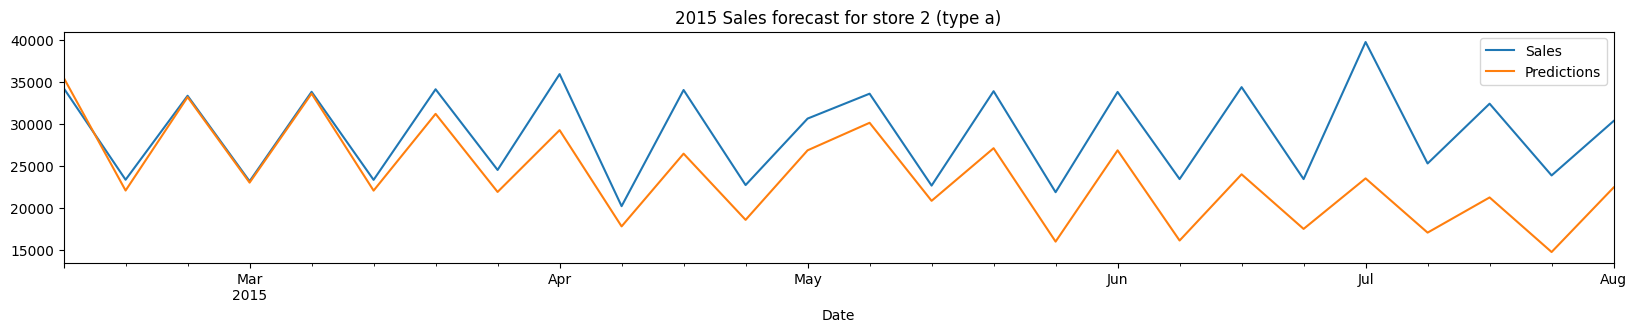

MAE: 5228.793980189103 -- MSE: 42573275.0053565


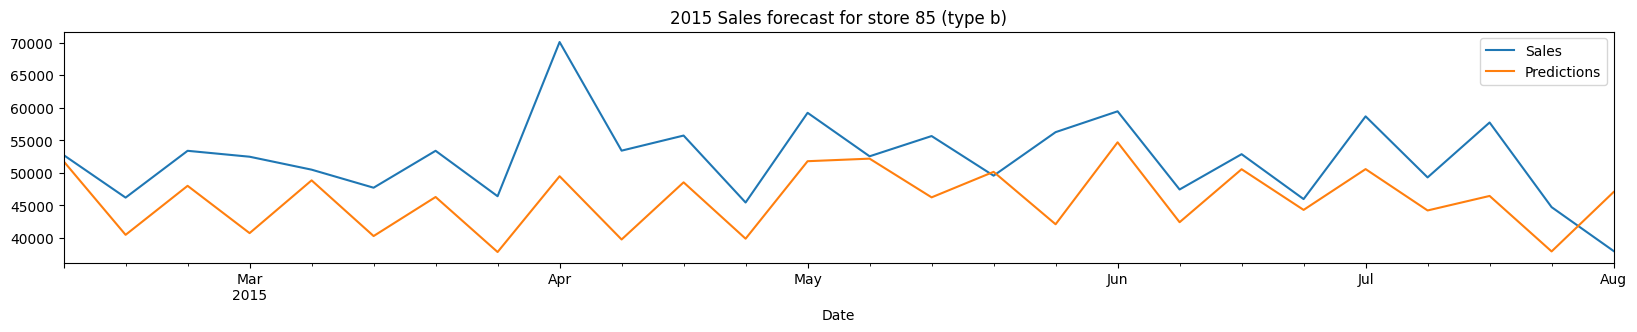

MAE: 6974.731009146984 -- MSE: 69965398.4866477


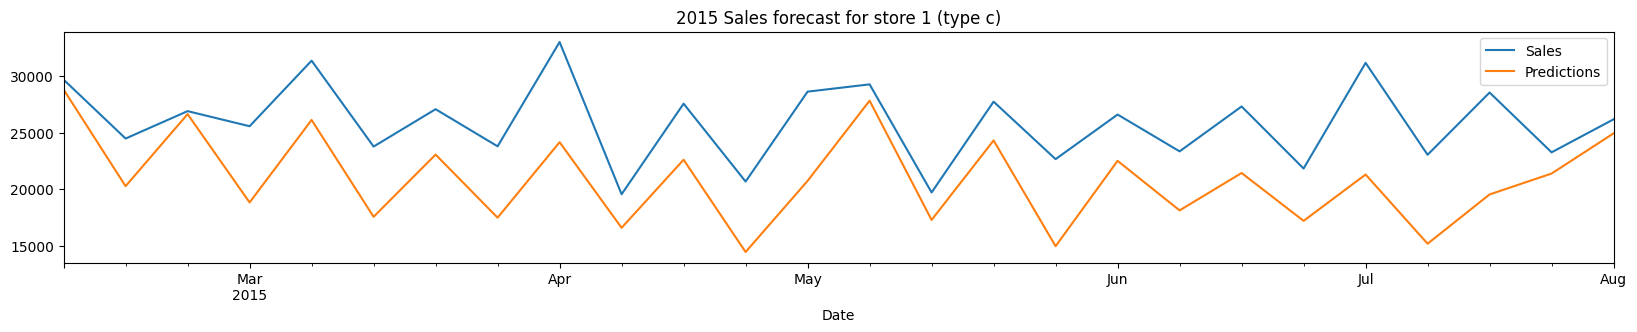

MAE: 4983.62800334758 -- MSE: 31730125.185733505


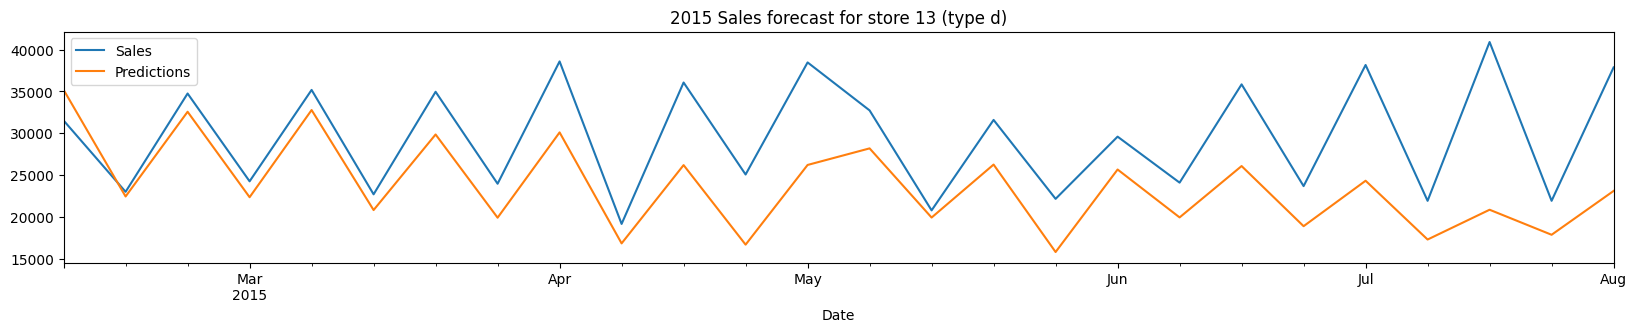

MAE: 6160.218665218617 -- MSE: 60008871.11549438


In [19]:
selected_stores = {
    "a": 2,
    "b": 85,
    "c": 1,
    "d": 13
}

for store_type, store_id in selected_stores.items():
    history_df = weekly_stores_sales_df[weekly_stores_sales_df.Store == store_id].set_index("Date")
    
    validation_sample = (
        validation_weekly_stores_sales_df[validation_weekly_stores_sales_df.Store == store_id].set_index("Date")
    )
    validation_trues = validation_sample.pop("Sales")
    
    results_df = get_forecast(validation_sample, history_df, xgbr_regressor)
    results_df["Sales"] = validation_trues
    
    mae = mean_absolute_error(results_df["Sales"], results_df["Predictions"])
    mse = mean_squared_error(results_df["Sales"], results_df["Predictions"])
    
    plt.figure()
    plt.title(f"2015 Sales forecast for store {store_id} (type {store_type})");

    ax = results_df["Sales"].plot(kind="line", figsize=(20, 3))
    results_df["Predictions"].plot(kind="line", ax=ax)
    ax.legend();
    plt.show()
    
    print(f"MAE: {mae} -- MSE: {mse}")

In [20]:
def objetive(trial):
    params = {
        "objective": "reg:squarederror",
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10.0),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
    }

    model = XGBRegressor(**params, random_state=42, nthread=-1, tree_method="hist")
    scorer = make_scorer(mean_squared_error)
    scores = cross_val_score(
        model,
        train_features,
        train_sales,
        cv=4,
        scoring=scorer,
        n_jobs=-1,
    )
    return np.mean(scores)

In [21]:
study = optuna.create_study(direction="minimize")
study.optimize(objetive, n_trials=100)

[I 2023-12-11 14:45:57,518] A new study created in memory with name: no-name-3f76adf3-f0f8-4efe-99f2-32bb7558b3be
[I 2023-12-11 14:46:01,675] Trial 0 finished with value: 0.04128278019057186 and parameters: {'max_depth': 7, 'min_child_weight': 4.320551897630707, 'subsample': 0.6803946823499095, 'colsample_bytree': 0.7484081329119008, 'learning_rate': 0.10226618166038688, 'n_estimators': 476}. Best is trial 0 with value: 0.04128278019057186.
[I 2023-12-11 14:46:06,424] Trial 1 finished with value: 0.04898309787651474 and parameters: {'max_depth': 8, 'min_child_weight': 8.511339163443017, 'subsample': 0.47529420927855115, 'colsample_bytree': 0.7003647814907713, 'learning_rate': 0.2516770818443773, 'n_estimators': 497}. Best is trial 0 with value: 0.04128278019057186.
[I 2023-12-11 14:46:09,289] Trial 2 finished with value: 0.05015307174934764 and parameters: {'max_depth': 7, 'min_child_weight': 5.354597729338843, 'subsample': 0.1725816528445825, 'colsample_bytree': 0.604222240775208, 'le

In [22]:
best_trial = study.best_trial
print(f"Best trial - Mean RMSE: {best_trial.value:.4f}")
print("Best trial parameters:")
for key, value in best_trial.params.items():
    print(f"\t- {key}: {value}")

Best trial - Mean RMSE: 0.0402
Best trial parameters:
	- max_depth: 8
	- min_child_weight: 0.7259161725753787
	- subsample: 0.8844630884454694
	- colsample_bytree: 0.9408378057638601
	- learning_rate: 0.05396499061420314
	- n_estimators: 438


In [23]:
final_xgbr_regressor = XGBRegressor(**best_trial.params, random_state=42)
final_xgbr_regressor.fit(train_features, train_sales)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9408378057638601, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05396499061420314, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=0.7259161725753787, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=438,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [24]:
mae = mean_absolute_error(train_sales, final_xgbr_regressor.predict(train_features))
mse = mean_squared_error(train_sales, final_xgbr_regressor.predict(train_features))

print(f"Train MAE: {mae:.4} -- Train MSE: {mse:.4}")

Train MAE: 0.09696 -- Train MSE: 0.02058


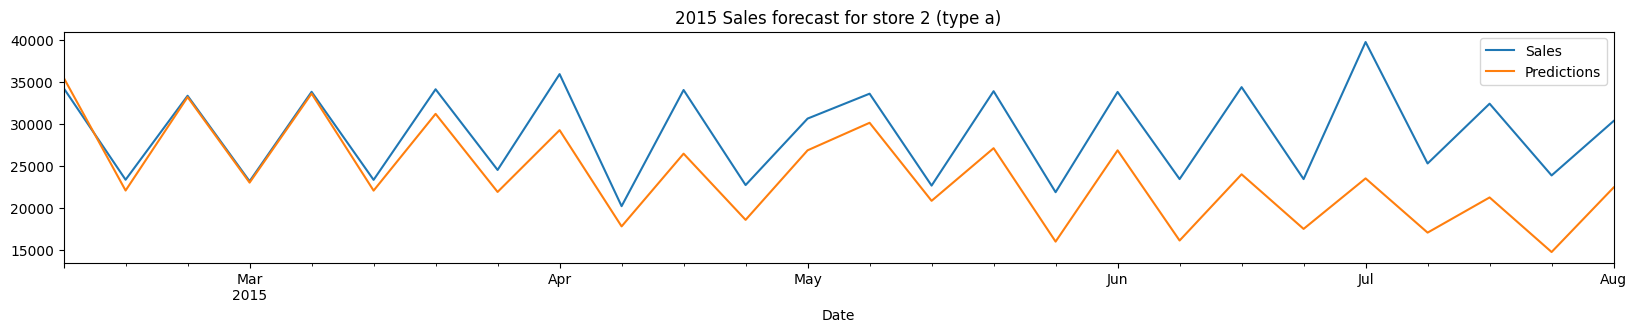

MAE: 5228.793980189103 -- MSE: 42573275.0053565


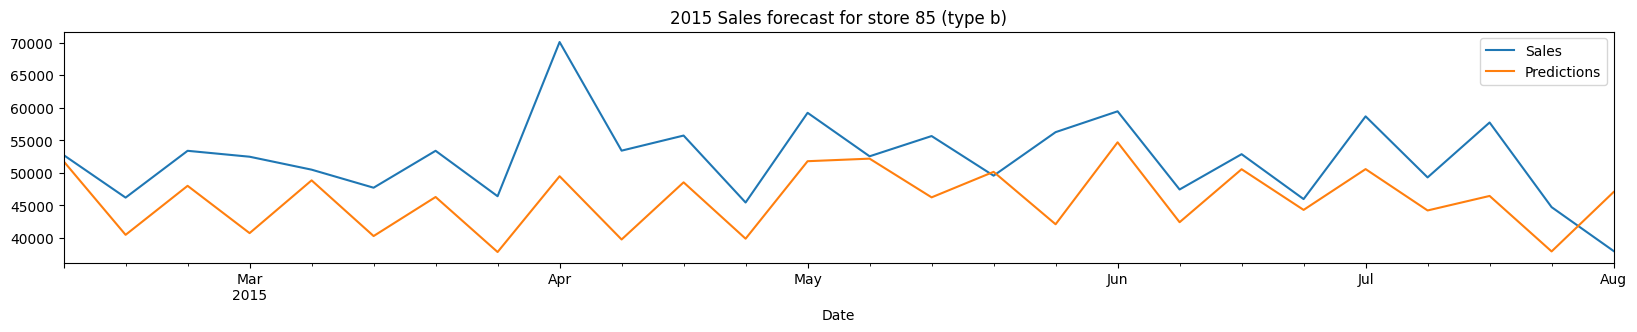

MAE: 6974.731009146984 -- MSE: 69965398.4866477


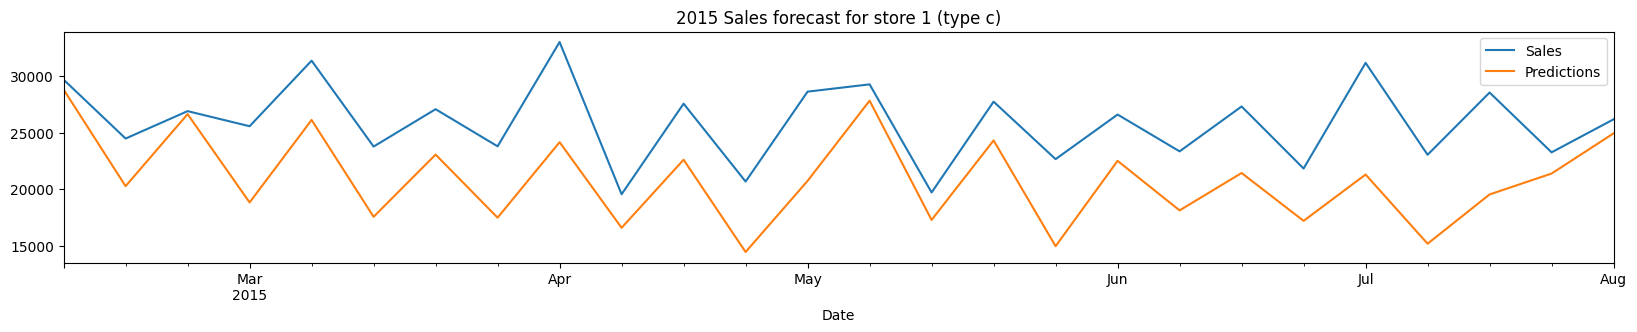

MAE: 4983.62800334758 -- MSE: 31730125.185733505


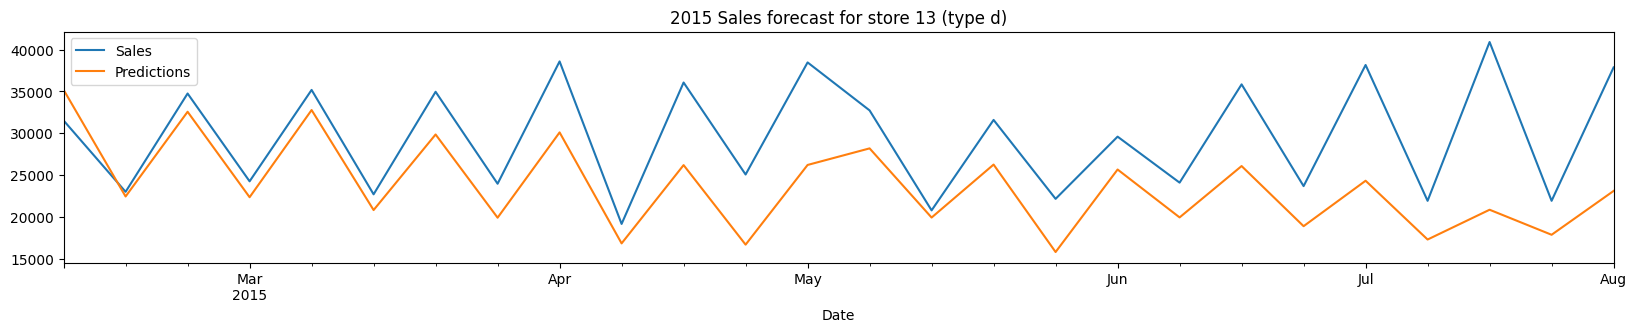

MAE: 6160.218665218617 -- MSE: 60008871.11549438


In [25]:
for store_type, store_id in selected_stores.items():
    history_df = weekly_stores_sales_df[weekly_stores_sales_df.Store == store_id].set_index("Date")
    
    validation_sample = (
        validation_weekly_stores_sales_df[validation_weekly_stores_sales_df.Store == store_id].set_index("Date")
    )
    validation_trues = validation_sample.pop("Sales")
    
    results_df = get_forecast(validation_sample, history_df, xgbr_regressor)
    results_df["Sales"] = validation_trues
    
    mae = mean_absolute_error(results_df["Sales"], results_df["Predictions"])
    mse = mean_squared_error(results_df["Sales"], results_df["Predictions"])
    
    plt.figure()
    plt.title(f"2015 Sales forecast for store {store_id} (type {store_type})");

    ax = results_df["Sales"].plot(kind="line", figsize=(20, 3))
    results_df["Predictions"].plot(kind="line", ax=ax)
    ax.legend();
    plt.show()
    
    print(f"MAE: {mae} -- MSE: {mse}")

In [26]:
stores_b_df = shuffled_weekly_stores_sales_df[
    shuffled_weekly_stores_sales_df.StoreType == 1
]
general_stores_df = shuffled_weekly_stores_sales_df[
    shuffled_weekly_stores_sales_df.StoreType != 1
]

display(stores_b_df)

,Store,Sales,Promo,StoreType,StateHoliday_0.0,StateHoliday_1.0,StateHoliday_2.0,StateHoliday_3.0,Year,Month,WeekOfYear,Sales_Lag1,Sales_Lag2,Sales_2Week_Avg
rnd_index,,,,,,,,,,,,,,
45,512,0.006444,0.0,1.0,True,False,False,False,2013,12,48,-0.062018,-0.215588,1.465110
59,423,1.409079,1.0,1.0,True,False,False,False,2015,1,2,1.932297,2.477729,1.546581
198,423,2.186850,1.0,1.0,True,False,False,False,2013,9,37,1.613802,2.289322,1.118834
270,512,0.013003,1.0,1.0,False,True,False,False,2013,5,18,-0.368551,-0.440044,-0.336084
275,335,3.418442,1.0,1.0,True,False,False,False,2014,10,43,1.892003,3.533812,-0.548524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89787,353,0.297433,1.0,1.0,True,False,False,False,2014,7,27,0.114924,0.167731,-0.204839
89918,423,2.147769,1.0,1.0,True,False,False,False,2014,10,41,2.260714,1.664569,0.193032
90007,562,5.135437,1.0,1.0,True,False,False,False,2013,3,10,4.387101,4.762151,-0.723537


In [27]:
stores_b_features, stores_b_sales = (
    stores_b_df.drop("Sales", axis="columns"),
    stores_b_df[["Sales"]],
)
general_stores_features, general_stores_sales = (
    general_stores_df.drop("Sales", axis="columns"),
    general_stores_df[["Sales"]],
)

In [28]:
stores_b_regressor = XGBRegressor()
stores_b_regressor.fit(stores_b_features, stores_b_sales)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
mae = mean_absolute_error(stores_b_sales, stores_b_regressor.predict(stores_b_features))
mse = mean_squared_error(stores_b_sales, stores_b_regressor.predict(stores_b_features))

print(f"Stores B Train MAE: {mae:.4} -- Stores B Train MSE: {mse:.4}")

Stores B Train MAE: 0.02724 -- Stores B Train MSE: 0.0015


In [30]:
general_stores_regressor = XGBRegressor()
general_stores_regressor.fit(general_stores_features, general_stores_sales)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
mae = mean_absolute_error(general_stores_sales, general_stores_regressor.predict(general_stores_features))
mse = mean_squared_error(general_stores_sales, general_stores_regressor.predict(general_stores_features))

print(f"General Stores Train MAE: {mae:.4} -- General Stores Train MSE: {mse:.4}")

General Stores Train MAE: 0.1127 -- General Stores Train MSE: 0.02891


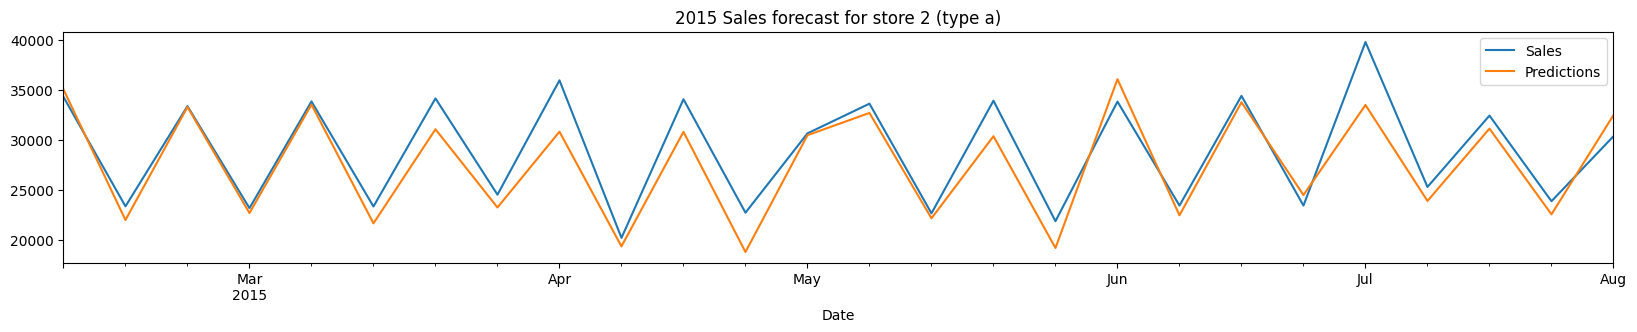

MAE: 1822.917070656616 -- MSE: 5688573.86067176


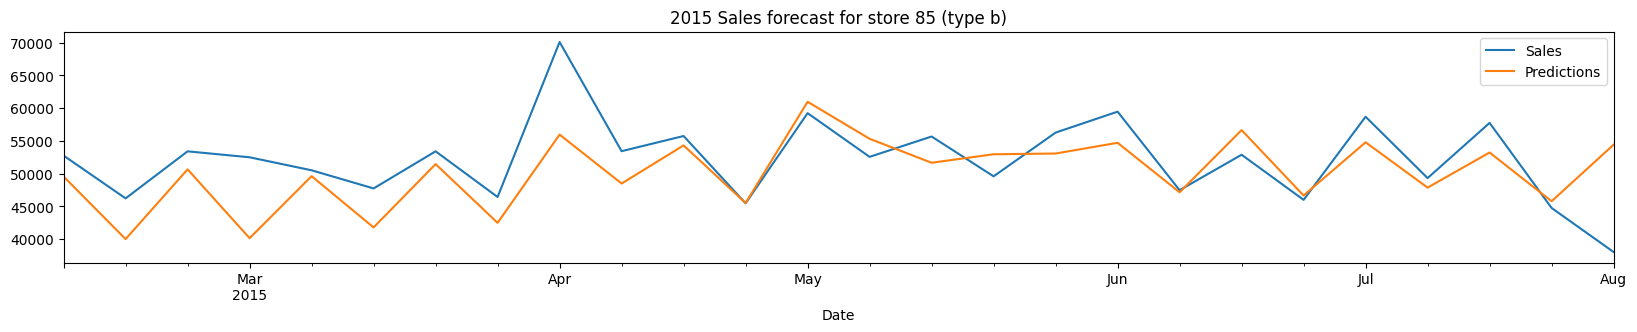

MAE: 4218.5067580269 -- MSE: 33993777.92464624


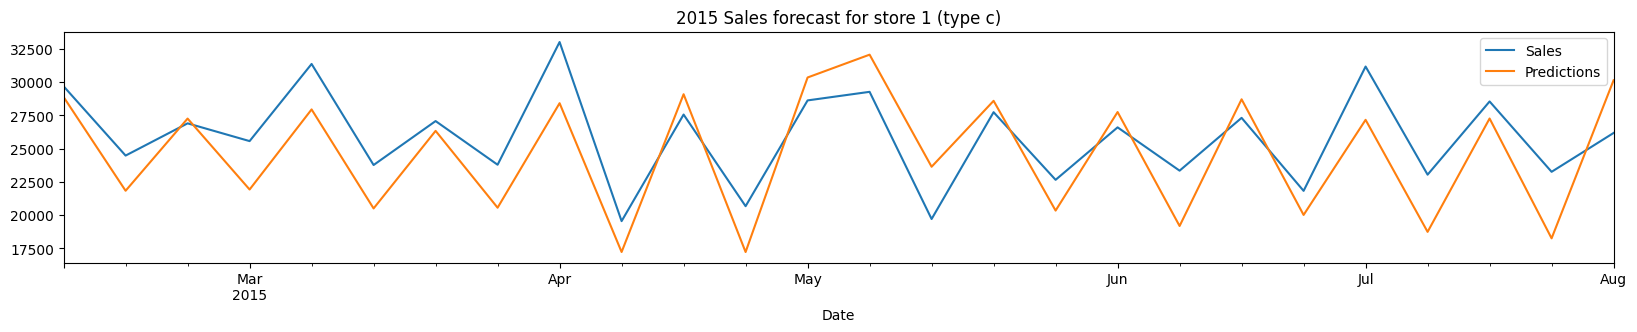

MAE: 2642.951932052528 -- MSE: 8784856.987549704


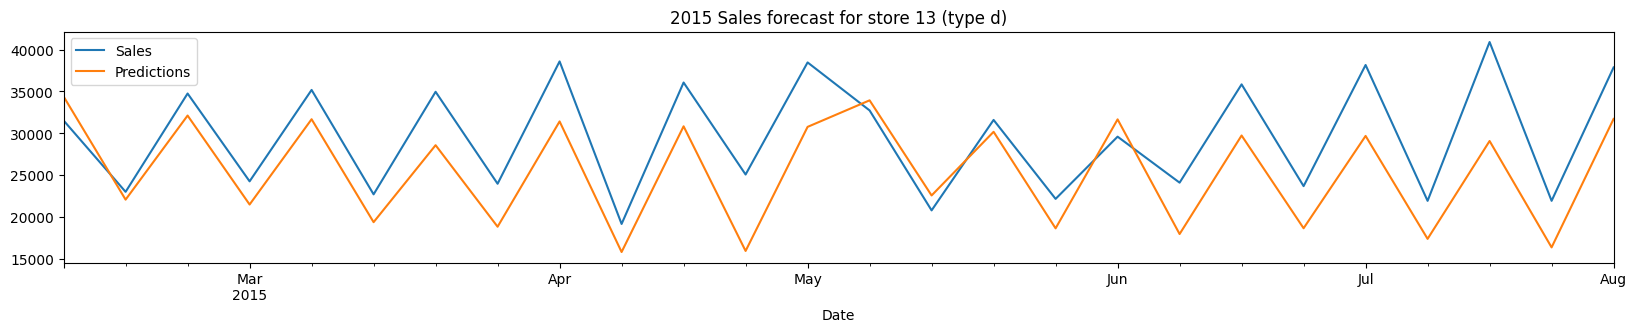

MAE: 4769.7889090055705 -- MSE: 29700230.964917906


In [32]:
for store_type, store_id in selected_stores.items():
    history_df = weekly_stores_sales_df[
        weekly_stores_sales_df.Store == store_id
    ].set_index("Date")

    validation_sample = validation_weekly_stores_sales_df[
        validation_weekly_stores_sales_df.Store == store_id
    ].set_index("Date")
    validation_trues = validation_sample.pop("Sales")

    regressor = stores_b_regressor if store_type == "b" else general_stores_regressor

    results_df = get_forecast(validation_sample, history_df, regressor)
    results_df["Sales"] = validation_trues

    mae = mean_absolute_error(results_df["Sales"], results_df["Predictions"])
    mse = mean_squared_error(results_df["Sales"], results_df["Predictions"])

    plt.figure()
    plt.title(f"2015 Sales forecast for store {store_id} (type {store_type})")

    ax = results_df["Sales"].plot(kind="line", figsize=(20, 3))
    results_df["Predictions"].plot(kind="line", ax=ax)
    ax.legend()
    plt.show()

    print(f"MAE: {mae} -- MSE: {mse}")